In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import torch.nn.functional as F
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:

class BaseModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BaseModel, self).__init__()
        seed = torch.randint(0, 1000, (1,)).item()
        torch.manual_seed(seed)
        # self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.nn = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    
    def forward(self, x):
        return self.nn(x)
    
class MetaModel(nn.Module):
    def __init__(self, meta_in_dim=8, meta_hidden_dim=16):
        super(MetaModel, self).__init__()
        self.meta_in_dim = meta_in_dim
        self.nn = nn.Sequential(
            nn.Linear(meta_in_dim+1, meta_hidden_dim),
            nn.ReLU(),
            nn.Linear(meta_hidden_dim, meta_hidden_dim),
            nn.ReLU(),
            nn.Linear(meta_hidden_dim, meta_in_dim)
        )
    
    def forward(self, flattened_weights):
        outs = []
        if len(flattened_weights.shape)==1:
            flattened_weights = flattened_weights.unsqueeze(0)

        segment_length = self.meta_in_dim
        total_segments = flattened_weights.shape[1]//self.meta_in_dim
        for i in range(0, flattened_weights.shape[1], segment_length):
            x = flattened_weights[:,i:i+self.meta_in_dim]
            segment_number = i//segment_length
            segment_feat = torch.tensor([((segment_number/total_segments)-.5)*2]).repeat(x.shape[0], 1).to(DEVICE)
            x = torch.cat([x, segment_feat], dim=1)
            # print("X shape", x.shape)   
            outs.append(self.nn(x))
        return torch.cat(outs, dim=1)

    
def init_weights(module, seed=0):
    torch.manual_seed(seed)
    
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
        nn.init.xavier_uniform_(module.weight)
        nn.init.zeros_(module.bias)


def modified_forward(x, seq, idx, params_dict):
    for i,layer in enumerate(seq):
        if isinstance(layer, nn.Linear):
            x = F.linear(x,
                        weight=params_dict[f'nn.{i}.weight'][idx],
                        bias=params_dict[f'nn.{i}.bias'][idx])
        elif isinstance(layer, nn.ReLU):
            x = torch.relu(x)
    return x


In [5]:

input_dim = 1
hidden_dim = 32
output_dim = 1
d = sum(p.numel() for p in BaseModel(input_dim, hidden_dim, output_dim).parameters()) +1

n=1000
X = torch.rand(n, input_dim)*4 -2
Y = torch.tanh(X)
# shuffle
perm = torch.randperm(n)
X = X[perm]
Y = Y[perm]
# random split
X_train, X_test = X[:int(n*0.8)], X[int(n*0.8):]
Y_train, Y_test = Y[:int(n*0.8)], Y[int(n*0.8):]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([800, 1]),
 torch.Size([800, 1]),
 torch.Size([200, 1]),
 torch.Size([200, 1]))

In [5]:
# 1 model
theta_f = BaseModel(input_dim, hidden_dim, output_dim).to(DEVICE)
meta_model = MetaModel(meta_in_dim=7, meta_hidden_dim=16).to(DEVICE)
optimizer = optim.Adam(meta_model.parameters(), lr=1e-2)
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
X_train = X_train.to(DEVICE)
Y_train = Y_train.to(DEVICE)

for epoch in range(15):
    optimizer.zero_grad()

    # what if we reinit on each iteration? ie can meta model predict final weights from scratch
    # theta_f = BaseModel(input_dim, hidden_dim, output_dim)  
    
    theta_flat = torch.cat([p.flatten() for p in theta_f.parameters()]).requires_grad_(True)
    theta_flat = torch.cat([theta_flat, torch.tensor([epoch], dtype=torch.float32,).to(DEVICE)]).requires_grad_(True)
    
    theta_flat_prime = meta_model(theta_flat).squeeze(0)
    
    theta_f_prime = BaseModel(input_dim, hidden_dim, output_dim)
    
    params_dict = {}
    start_idx = 0
    for name, param in theta_f_prime.named_parameters():
        param_length = param.numel()
        params_dict[name] = theta_flat_prime[start_idx:start_idx + param_length].view(1,*param.shape)
        start_idx += param_length

    outputs = modified_forward(X_train, theta_f_prime.nn, 0, params_dict)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}, Train Loss {loss.item()}')
    
    if epoch == 0:
        make_dot(loss, params=dict(list(meta_model.named_parameters()))).render('comp_graph', format='png')
        

Epoch 0, Train Loss 1.0710959434509277
Epoch 1, Train Loss 0.893869161605835
Epoch 2, Train Loss 0.7391670346260071
Epoch 3, Train Loss 0.6038690209388733
Epoch 4, Train Loss 0.4780109226703644
Epoch 5, Train Loss 0.35249099135398865
Epoch 6, Train Loss 0.22010397911071777
Epoch 7, Train Loss 0.10554607957601547
Epoch 8, Train Loss 0.060339707881212234
Epoch 9, Train Loss 0.10264185070991516
Epoch 10, Train Loss 0.16317462921142578
Epoch 11, Train Loss 0.12247287482023239
Epoch 12, Train Loss 0.04785441234707832
Epoch 13, Train Loss 0.05460574850440025
Epoch 14, Train Loss 0.11274286359548569


In [6]:
# numel
optimizee_params = sum(p.numel() for p in BaseModel(input_dim, hidden_dim, output_dim).parameters())
meta_model_params = sum(p.numel() for p in meta_model.parameters())

print(f"Optimizee params: {optimizee_params}, Meta model params: {meta_model_params}") # currently meta_model >> optimizee.

Optimizee params: 97, Meta model params: 519


In [7]:
#k models
k = 1000
batch_size = 16
optimizees = [BaseModel(input_dim, hidden_dim, output_dim) for _ in range(k)]
meta_model = MetaModel(7,16).to(DEVICE)
optimizer = optim.Adam(meta_model.parameters(), lr=1e-2)
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
X_train = X_train.to(DEVICE)
Y_train = Y_train.to(DEVICE)



for epoch in range(25):
    running_loss = 0.0
    for i in range(0, k, batch_size):
        batch = optimizees[i:i+batch_size]
        batch_flattened = [torch.cat([torch.cat([p.flatten() for p in model.parameters()]), torch.tensor([epoch], dtype=torch.float32)]) for model in batch]
        batch_flattened = torch.stack(batch_flattened).to(DEVICE)
        optimizer.zero_grad()

        theta_flat_prime = meta_model(batch_flattened)
        
        batch_prime = [BaseModel(input_dim, hidden_dim, output_dim) for _ in range(theta_flat_prime.shape[0])]
        params_dict = {}
        start_idx = 0
        for name, param in batch_prime[0].named_parameters():
            param_length = param.numel() 
            try:
                params_dict[name] = theta_flat_prime[:, start_idx:start_idx + param_length].view(theta_flat_prime.shape[0], *param.shape)
            except:
                print(name, param_length, theta_flat_prime[:, start_idx:start_idx + param_length].shape)
                break
            start_idx += param_length

        # outputs = [modified_forward(X_train, i) for i in range(len(batch_prime))]
        outputs = [modified_forward(X_train, batch_prime[i].nn, i, params_dict) for i in range(len(batch_prime))]
        # reassign the outputs to the models
        for i, model in enumerate(optimizees[i:i+batch_size]):
            for name, param in model.named_parameters():
                param.data = params_dict[name][i].cpu()
        loss = torch.stack([criterion(output, Y_train) for output in outputs]).mean()
        loss.backward()
        running_loss += loss.item() * len(batch)
        optimizer.step()
    print(f'Epoch {epoch}, Train Loss {running_loss/len(optimizees)}')
        



Epoch 0, Train Loss 0.063697474014014
Epoch 1, Train Loss 0.031823301747441295
Epoch 2, Train Loss 0.009406756018288434
Epoch 3, Train Loss 0.005175284341908991
Epoch 4, Train Loss 0.003186521677300334
Epoch 5, Train Loss 0.002257615766953677
Epoch 6, Train Loss 0.001552983481436968
Epoch 7, Train Loss 0.001157976841321215
Epoch 8, Train Loss 0.0008096691267564893
Epoch 9, Train Loss 0.0006756183360703289
Epoch 10, Train Loss 0.0006539915823377669
Epoch 11, Train Loss 0.0005257102355826646
Epoch 12, Train Loss 0.000503846971783787
Epoch 13, Train Loss 0.00046089459490031005
Epoch 14, Train Loss 0.00041583710466511545
Epoch 15, Train Loss 0.00042787148407660424
Epoch 16, Train Loss 0.0003831753011327237
Epoch 17, Train Loss 0.00038321800786070525
Epoch 18, Train Loss 0.0003663084476720542
Epoch 19, Train Loss 0.00034297716058790686
Epoch 20, Train Loss 0.00034826450143009426
Epoch 21, Train Loss 0.00032680845563299953
Epoch 22, Train Loss 0.00032551399921067057
Epoch 23, Train Loss 0.00

In [8]:
# evaluate overparameterized meta optimizer
k_test = 100
batch_size = 8
optimizees = [BaseModel(input_dim, hidden_dim, output_dim) for _ in range(k_test)]
optimizees_for_adam = [deepcopy(model) for model in optimizees]
meta_model.to(DEVICE)
meta_model.eval()
X_train = X_train.to(DEVICE)
Y_train = Y_train.to(DEVICE)

# initial evaluation on train
initial_losses = [] 
with torch.no_grad():
    for model in optimizees:
        model.to(DEVICE)
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        initial_losses.append(loss.item())
    print(f'Initial Train Loss {sum(initial_losses)/len(optimizees)}')

epochs = 25
losses_meta = [[] for _ in range(epochs+1)]
losses_meta[0] = initial_losses

for epoch in range(epochs):
    running_loss = 0.0
    for i in range(0, k_test, batch_size):
        batch = optimizees[i:i+batch_size]
        batch_flattened = [torch.cat([torch.cat([p.flatten() for p in model.parameters()]), torch.tensor([epoch], dtype=torch.float32).to(DEVICE)]) for model in batch]
        batch_flattened = torch.stack(batch_flattened).to(DEVICE)

        theta_flat_prime = meta_model(batch_flattened)
        
        batch_prime = [BaseModel(input_dim, hidden_dim, output_dim) for _ in range(theta_flat_prime.shape[0])]
        params_dict = {}
        start_idx = 0
        for name, param in batch_prime[0].named_parameters():
            param_length = param.numel() 
            params_dict[name] = theta_flat_prime[:, start_idx:start_idx + param_length].view(theta_flat_prime.shape[0], *param.shape)
            
            start_idx += param_length

        
        outputs = [modified_forward(X_train, batch_prime[i].nn, i, params_dict) for i in range(len(batch_prime))]
        # reassign the weights for the next iteration
        for i, model in enumerate(batch):
            for name, param in model.named_parameters():
                param.data = params_dict[name][i].data

        loss = torch.stack([criterion(output, Y_train) for output in outputs])
        losses_meta[epoch+1].extend(loss.clone().detach().flatten().squeeze().cpu().numpy().tolist())
        loss = loss.mean()
        running_loss += loss.item() * len(batch)
    print(f'Epoch {epoch}, eval Train Loss {running_loss/len(optimizees)}')


losses_adam = [[] for _ in range(epochs+1)]
losses_adam[0] = initial_losses
for model in optimizees_for_adam:
    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        loss.backward()
        optimizer.step()
        losses_adam[epoch+1].append(loss.item())
    print(f'Epoch {epoch}, Adam Train Loss {loss.item()}')


Initial Train Loss 0.5619182939827442
Epoch 0, eval Train Loss 0.1667139571905136
Epoch 1, eval Train Loss 0.17691565096378326
Epoch 2, eval Train Loss 0.17047459602355958
Epoch 3, eval Train Loss 0.15932077050209045
Epoch 4, eval Train Loss 0.1468774390220642
Epoch 5, eval Train Loss 0.1339113509654999
Epoch 6, eval Train Loss 0.12152621656656265
Epoch 7, eval Train Loss 0.10974109172821045
Epoch 8, eval Train Loss 0.09838734477758408
Epoch 9, eval Train Loss 0.08709530532360077
Epoch 10, eval Train Loss 0.07579180896282196
Epoch 11, eval Train Loss 0.0652143806219101
Epoch 12, eval Train Loss 0.05542971178889275
Epoch 13, eval Train Loss 0.046443227231502536
Epoch 14, eval Train Loss 0.038255318999290466
Epoch 15, eval Train Loss 0.03086600348353386
Epoch 16, eval Train Loss 0.024275329113006592
Epoch 17, eval Train Loss 0.018483226895332338
Epoch 18, eval Train Loss 0.013489736989140511
Epoch 19, eval Train Loss 0.009412897899746895
Epoch 20, eval Train Loss 0.006100185420364141
Epo

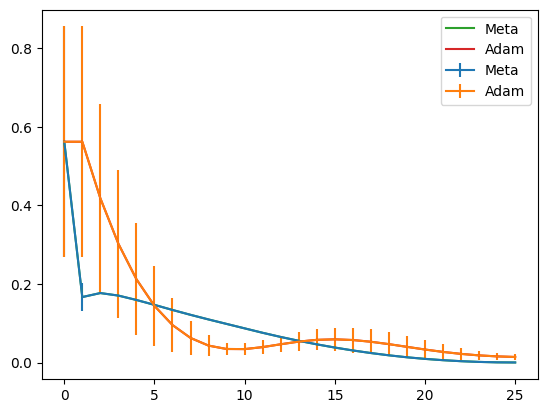

In [9]:
# plto
avg_losses_meta = [sum(losses)/len(losses) for losses in losses_meta]
avg_losses_adam = [sum(losses)/len(losses) for losses in losses_adam]

# error bars
std_losses_meta = [torch.tensor(losses).std().item() for losses in losses_meta]
std_losses_adam = [torch.tensor(losses).std().item() for losses in losses_adam]

plt.errorbar(range(epochs+1), avg_losses_meta, yerr=std_losses_meta, label='Meta')
plt.errorbar(range(epochs+1), avg_losses_adam, yerr=std_losses_adam, label='Adam')


plt.plot(avg_losses_meta, label='Meta')
plt.plot(avg_losses_adam, label='Adam')
plt.legend()
plt.show()

In [4]:
# import mnist
import torchvision
import torchvision.transforms as transforms
new_mirror = 'https://ossci-datasets.s3.amazonaws.com/mnist'
torchvision.datasets.MNIST.resources = [
   ('/'.join([new_mirror, url.split('/')[-1]]), md5)
   for url, md5 in torchvision.datasets.MNIST.resources
]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,),
     )])

trainset = torchvision.datasets.MNIST(root='./.data', train=True, download=True, transform=transform)
trainset = [(trainset[i][0].flatten(), trainset[i][1]) for i in range(len(trainset))]
testset = torchvision.datasets.MNIST(root='./.data', train=False, download=True, transform=transform)   
testset = [testset[i][0].flatten() for i in range(len(testset))]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)


In [5]:
class MNIST_MLP(nn.Module):
    def __init__(self):
        super(MNIST_MLP, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(28*28, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )
    def forward(self, x):
        return self.nn(x)
    
print("MNIST MLP #params: ", sum(p.numel() for p in MNIST_MLP().parameters()))


MNIST MLP #params:  25450


In [24]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

model = MNIST_MLP().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch}, Train Loss {running_loss/len(trainloader)}')

Epoch 0, Train Loss 0.418510689808925
Epoch 1, Train Loss 0.2677950159450372
Epoch 2, Train Loss 0.21923765747348467
Epoch 3, Train Loss 0.18910806164443492
Epoch 4, Train Loss 0.1710364762460192


In [7]:
25451/31

821.0

In [19]:
print("Optimzee # params", sum(p.numel() for p in MNIST_MLP().parameters()))
print("Meta model # params", sum(p.numel() for p in MetaModel(821, 512).parameters()))

Optimzee # params 25450
Meta model # params 1105205


In [20]:
k = 100
batch_size = 16
optimizees = [MNIST_MLP().to(DEVICE) for _ in range(k)]

meta_model = MetaModel(meta_in_dim=31, meta_hidden_dim=64).to(DEVICE)
optimizer = optim.Adam(meta_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# initial_losses = []
# with torch.no_grad():
#     for model in optimizees:
#         model.to(DEVICE)
#         model.eval()
#         running_loss = 0.0
#         for i, data in enumerate(trainloader):
#             inputs, labels = data
#             inputs = inputs.to(DEVICE)
#             labels = labels.to(DEVICE)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             running_loss += loss.item()
#         initial_losses.append(running_loss/len(trainloader))
#     print(f'Initial Train Loss {sum(initial_losses)/len(optimizees)}')

epochs = 250
losses_meta = [[] for _ in range(epochs+1)]
initial_losses = 0
losses_meta[0] = initial_losses

for epoch in range(epochs):
    running_loss = 0.0
    for i in range(0, k, batch_size):
        print("starting batch", (i//batch_size)+1)
        batch = optimizees[i:i+batch_size]
        batch_flattened = [torch.cat([torch.cat([p.flatten() for p in model.parameters()]), torch.tensor([epoch], dtype=torch.float32).to(DEVICE)]) for model in batch]
        batch_flattened = torch.stack(batch_flattened).to(DEVICE)

        optimizer.zero_grad()
        theta_flat_prime = meta_model(batch_flattened)
        
        mnist_nn = MNIST_MLP()
        mnist_seq = mnist_nn.nn
        params_dict = {}
        start_idx = 0
        for name, param in mnist_nn.named_parameters():
            param_length = param.numel() 
            params_dict[name] = theta_flat_prime[:, start_idx:start_idx + param_length].view(theta_flat_prime.shape[0], *param.shape)
            
            start_idx += param_length
        
        # shuffle trainloader
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True,pin_memory=True)
        it = iter(trainloader)
        outputs = []
        labels = []
        for i in range(theta_flat_prime.shape[0]):
            inputs, label = next(it)
            inputs = inputs.to(DEVICE)
            label = label.to(DEVICE) 
            out = modified_forward(inputs, mnist_seq, i, params_dict)
            loss = criterion(out, label)
            retain_graph = i < theta_flat_prime.shape[0] - 1
            loss.backward(retain_graph=retain_graph)
            losses_meta[epoch+1].append(loss.item())    
        # reassign the weights for the next iteration
        for i, model in enumerate(batch):
            for name, param in model.named_parameters():
                param.data = params_dict[name][i].data
        optimizer.step()
    print(f'Epoch {epoch}, meta Train Loss {torch.mean(torch.tensor(losses_meta[epoch+1]))}')

starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting batch 6
starting batch 7
Epoch 0, meta Train Loss 2.7210097312927246
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting batch 6
starting batch 7
Epoch 1, meta Train Loss 2.319272756576538
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting batch 6
starting batch 7
Epoch 2, meta Train Loss 2.303067922592163
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting batch 6
starting batch 7
Epoch 3, meta Train Loss 2.304128646850586
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting batch 6
starting batch 7
Epoch 4, meta Train Loss 2.3047678470611572
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting batch 6
starting batch 7
Epoch 5, meta Train Loss 2.3047237396240234
starting batch 1
starting

KeyboardInterrupt: 